# **Maternal Health Risk Study A**

## Objectives

* Answer Buisiness requirement 1. Carry out descriptive analytics on the maternal health dataset.
  
## Inputs

* The maternal health dataset from outputs/datasets/collection/maternal-healt-dataset.csv

## Outputs

* Code to answer business requirement 1 and to use to build a Streamlit dashboard
* Plots to visualise the analysis

## Additional Comments
* This is the first part of the maternal health risk study and contains exploratory data analysis of the data set, outlier study and correlation study.
* See part B of this notebook for the rest of the analysis (EDA of selected correlated variables)

---

# Import Packages for Descriptive Data Analysis

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

%matplotlib inline

# Change working directory

We need to change the working directory from its current folder to its parent folder
* Access current directory with os.getcwd()

In [2]:
current_dir = os.getcwd()
current_dir

'/workspaces/ML-maternal-health-risk/jupyter_notebooks'

Make the parent of the current directory the new current directory, and confirm new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory
* os.getcwd() get the current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print(f"New current directory set to {current_dir}.")

New current directory set to /workspaces/ML-maternal-health-risk.


# Load Data

In [9]:
df = pd.read_csv('outputs/datasets/collection/maternal-health-risk-dataset.csv')
df.head()

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,36.7,86,2
1,35,140,90,13.0,36.7,70,2
2,29,90,70,8.0,37.8,80,2
3,30,140,85,7.0,36.7,70,2
4,35,120,60,6.1,36.7,76,0


---

# Data Exploration

In this section we perform a first exploratory data analysis on the dataset.

In [5]:
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 115.86it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Notes from the profiling report:

* The target variable (RiskLevel) has three classes and 40% of the target variables are zero (low risk).
  * This could be a hint that the dataset is imbalanced.
  * Depending on the balance of the other two classes, this could indicate significant or mild imbalance and we might need to consider rebalancing the dataset during the feature engineering step.
  * The class distribution is: 40%, 33.1%, 26.8%. This is a more moderate imbalance and ML algorithms might perform well enough without rebalancing.
  * We will keep this in mind for the case where one class has notably worse results in prediction.
* There are no missing values in any column.

---

# Outlier Study

In this section we look at outliers to get a first impression and see whether there could be possible errors in the dataset.

We will further handle the outliers in the data cleaning and feature engineering notebooks.

### Short Statictical Summary

We look at a quick statistical summary of the dataset to check the averages and also the min and max to get a first impression on possible outliers/extreme values etc. 

In [10]:
df.describe()

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,37.059763,74.301775,0.867850
std,13.474386,18.403913,13.885796,3.293532,0.743991,8.088702,0.807353
min,10.000000,70.000000,49.000000,6.000000,36.700000,7.000000,0.000000
25%,19.000000,100.000000,65.000000,6.900000,36.700000,70.000000,0.000000
50%,26.000000,120.000000,80.000000,7.500000,36.700000,76.000000,1.000000
75%,39.000000,120.000000,90.000000,8.000000,36.700000,80.000000,2.000000
max,70.000000,160.000000,100.000000,19.000000,39.400000,90.000000,2.000000


We start by looking at the min and max values:

* We notice that the minimum value for age is 10 and the maximum value for age ist 70 years old, which seems odd for data about pregnancy.
  * There are many values in the age column that seem questionable, these would need to be further discussed with the client. For this project we decide to keep all that are not outliers, since they      
    provide important data points.
* Since we look at medical data, it is useful to gather information about normal ranges of the other variables:
* Blood Pressure (mm Hg) (from [Blood Pressure UK](https://www.bloodpressureuk.org/your-blood-pressure/understanding-your-blood-pressure/what-do-the-numbers-mean/)):
  * low blood pressure: 70-90 systolic and 40-60 diastolic
  * ideal blood pressure: 90-120 systolic and 60-80 diastolic
  * pre-high blood pressure: 120-140 systolic and 80-90 diastolic
  * high blood pressure: 140-190 systolic and 90-100 diastolic
  * Blood pressure values in the dataset look to be in a realistic range
* Blood Sugar (mmol/L):
  * Min and Max values seem to be in a normal range, even though we do not have enough details about the measurement (i.e. at what time was the measurement taken etc.).
* Body Temperature looks to be in a normal range.
* Heart Rate seems to be in a normal range, except for one obvious outlier (HR 7) which must be an error.

In [11]:
df.query("HeartRate < 60")

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
499,16,120,75,7.9,36.7,7,0
908,16,120,75,7.9,36.7,7,0


In [15]:
df.query("Age >= 70")

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
338,70,85,60,6.9,38.9,70,0


### Visualise Outliers

To visualise the outliers, let us create a boxplot for each variable.

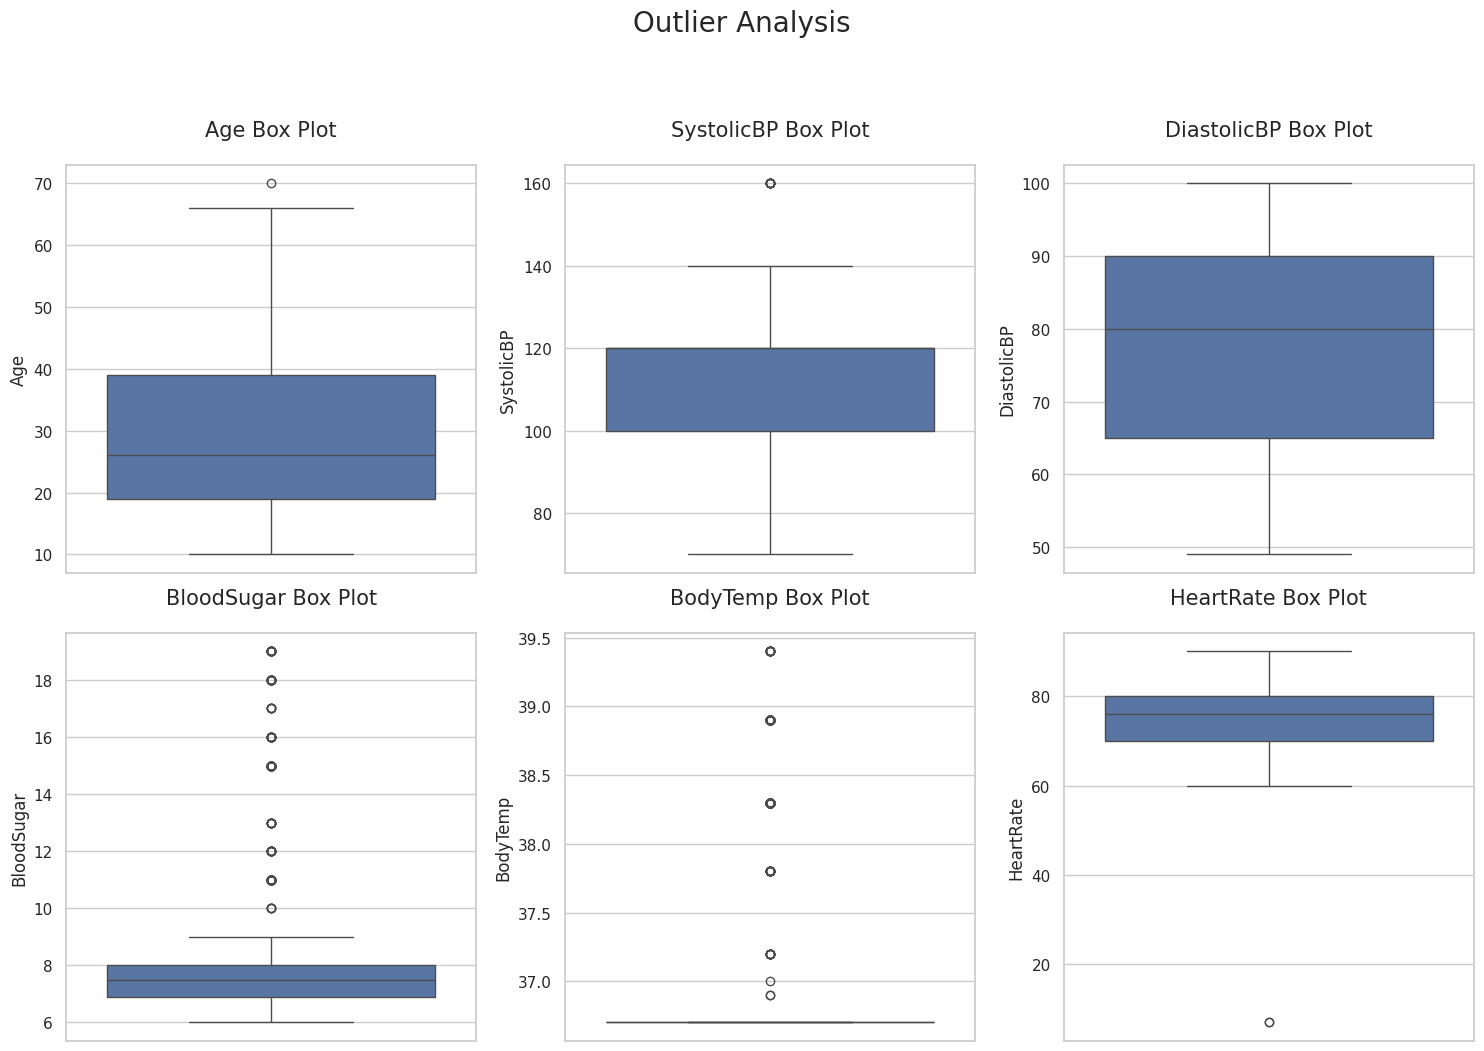

In [25]:
sns.set_theme(style="whitegrid")

fig_out, axes = plt.subplots(2, 3, figsize=(15, 10))
fig_out.suptitle("Outlier Analysis", fontsize=20, y=1.05)

# define index list:
ind_list = []
for i in range(2):
    for j in range(3):
        ind_list.append([i,j])

for ind, var in enumerate(df.columns[:-1]):
    i, j = ind_list[ind]
    sns.boxplot(ax=axes[i, j], data=df[var])
    axes[i, j].set_title(f"{var} Box Plot", fontsize=15, y=1.05)


plt.tight_layout()
plt.show()

### Outlier Summary

* The outliers in age and heartrate most likely stem from erronous data entries and we will drop them in the data cleaning notebook. This is no problem for our model since only a few data points are effected.
* Body temperature, systolic BP and blood sugar have outliers, some of which quite far from the rest of the distribution.
  * In an earlier analysis we decided to keep these values since they are in a realistic medical range and could provide vital information about extreme health cases to out model. 
  * Especially for systolic BP and blood sugar levels we can see in the next notebook in the section 'Distribution by RiskLevel for each Variable' that high levels of these features indeed stongly indicate a high risk level, thus the information included in these datapoints is relevant.
  * However, these extreme values led to a biased model and we could increase model performance significanlty by adding outlier handling for these features.
    * e.g. high-risk recall increased from 88% to 94% for the train set and from 78% to 87% for the test set after adding a winsorizer step to the pipeline (see README.md for more details).
  * Since our dataset is relatively small it is reasonable to assume that the extreme values influenced the model too much and it makes sense to handle these outliers with e.g. a winsorizer.
  * In a much larger dataset one could consider keeping the outliers and checking how the model behaves.
* We are aware that in a real world application we would discuss these questions with the medical experts and stakeholders.

For now, let us note to remove the single outliers in age and heartrate in the data cleaning notebook and look at outlier winsorization for body temperature, systolic BP and blood sugar in the feature engineering notebook.

---

# Correlation Study

In this section we study correlation in the dataset.

We are interested in
* the correlation of each feature with the target
* correlation between the features to find possible collinearity

Note that the focus in this notebook is on the correlation of the features with the target variable. We leave a more detailed study of the correlations between the features , as well as a predictive power score (PPS) analysis to the data cleaning notebook, after the data is cleaned.

We start by looking at the correlation levels of RiskLevel with all the features. We drop the correlation of the target with itself and sort the correlation levels by absolute value (key=abs) in descending order to find the most relevant correlated variables.

Since the variables are not normally distributed and not all of them (most notably the target) are continuous, the Spearman's correlation is the one we have to consider. 

With our discrete target variable Pearson's correlation does not make sense.

In [19]:
corr_vars_spearman = df.corr(method='spearman')["RiskLevel"].sort_values(key=abs, ascending=False).drop("RiskLevel")
corr_vars_spearman

BloodSugar     0.445289
SystolicBP     0.398284
DiastolicBP    0.319186
Age            0.289031
HeartRate      0.186077
BodyTemp       0.166797
Name: RiskLevel, dtype: float64

### Heatmap

Let us now visualise the correlations of all variables in a heatmap.

We will look into this in more detail in the feature engineering notebook.

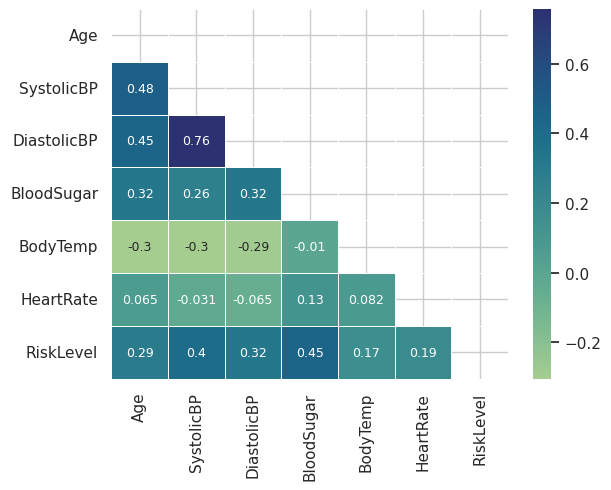

In [20]:
df_corr = df.corr(method="spearman")
# Create a mask to cover the upper triangle of the heatmap since the data is symetric
# Get zeros in the shape of df_corr of boolean type
upper_mask = np.zeros_like(df_corr, dtype=np.bool)
# Select all indices in the upper right triangle and set to True
upper_mask[np.triu_indices_from(upper_mask)] = True
sns.heatmap(data=df_corr, annot=True, mask=upper_mask, linewidths=0.7, annot_kws={"size": 9}, cmap='crest')
plt.show()

### Conclusions from Correlation Study

* For both methods we notice mostly weak and some moderate correlation levels between the target and the features.
* The variable with the strongest correlation is BloodSugar.
* We include all variables with correlation levels greate than 0.2 in the further study.
* Hence, we drop HeartRate and BodyTemp for now since they only correlate weakly to the RiskLevel.
* Also note that all correlation levels are positive meaning that when one variable increases also the RiskLevel increases.
* Most notable this analysis leads us to suspect that:
  * Patients with high risk tend to have high blood sugar levels
  * Patients with high risk tend to have high systolic blood pressure levels
  * Patients with high risk tend to have high diasystolic blood pressure levels
  * Patients with high risk tend to be of a higher age

We now take the four weak to moderately correlated variables, store them in corr_vars and perform further analysis in the next section. 

In [21]:
corr_vars_study = corr_vars_spearman[:4].index.to_list()
corr_vars_study 

['BloodSugar', 'SystolicBP', 'DiastolicBP', 'Age']

## Push files to Repo

Save plots to documentation folder

In [22]:
try:
  os.makedirs(name='documentation/plots') # create documentation/plots folder
except Exception as e:
  print(e)

[Errno 17] File exists: 'documentation/plots'


### Box Plots

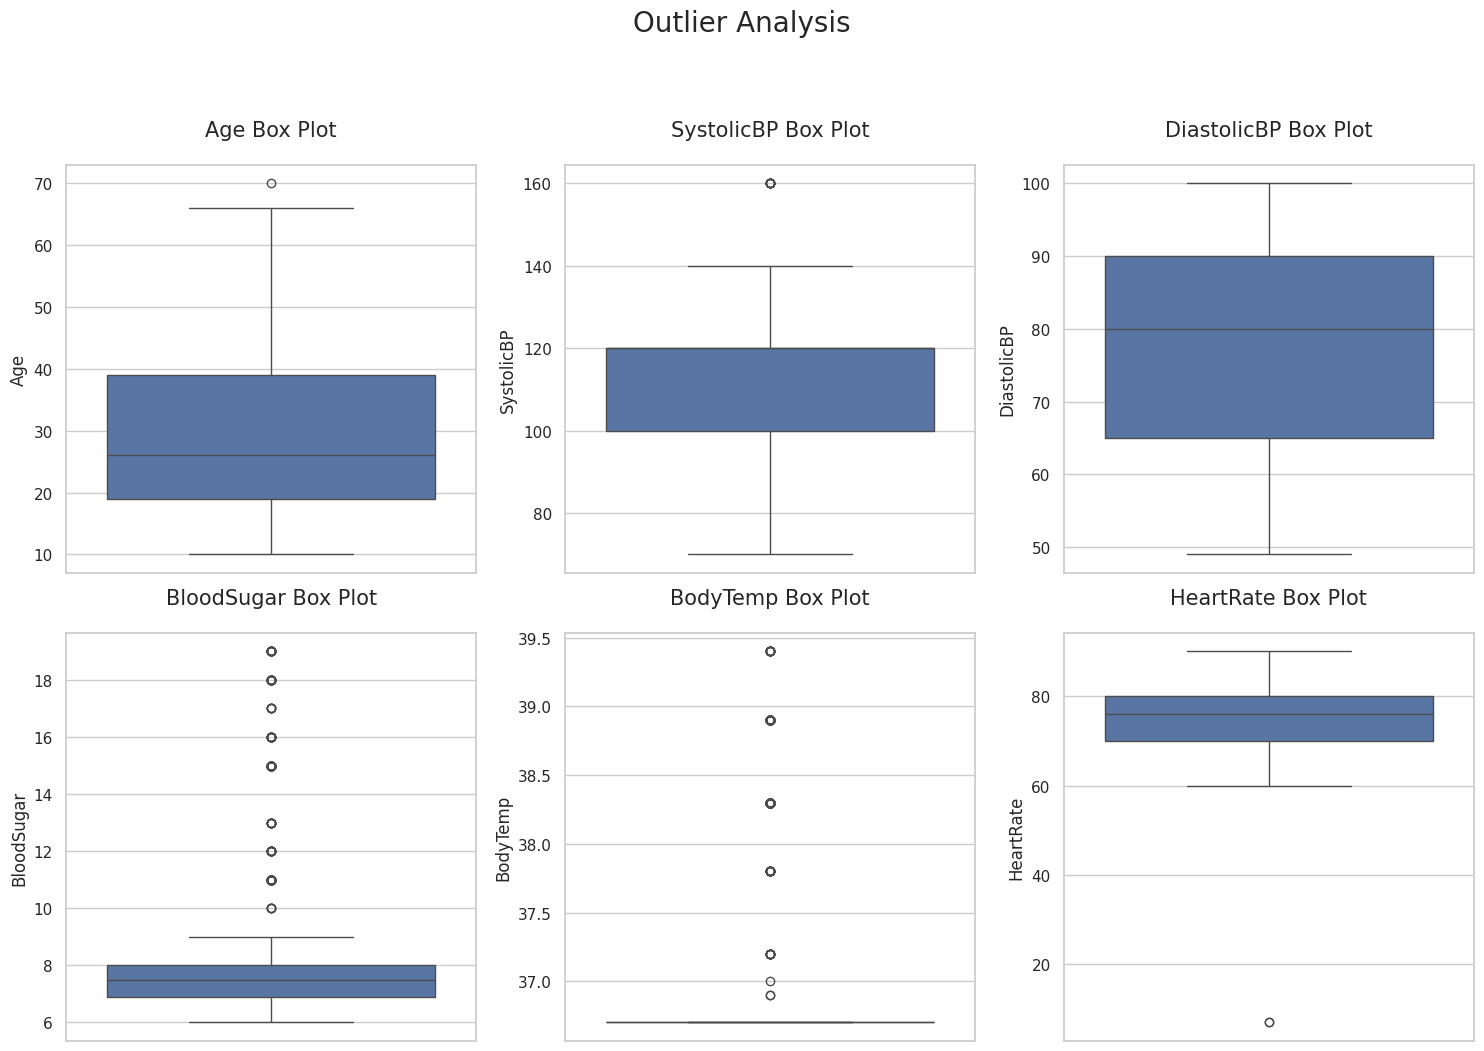

In [26]:
fig_out

In [27]:
fig_out.savefig(f"documentation/plots/box-plots.png")

---

# Conclusions and Next Steps



In this notebook we conducted a first exploratory data analysis and then studied outliers and correlation between the features and the target.

We continue our analysis in the next notebook 03-MaternalHealthRiskStudyB.ipynb